In [6]:
import argparse
import gc
import logging
import os

import sys
# sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')


import time

from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim

from sgan.data.loader import data_loader
from sgan.losses_argo import gan_g_loss, gan_d_loss, l2_loss
from sgan.losses_argo import displacement_error, final_displacement_error

from sgan.models_argo import TrajectoryGenerator, TrajectoryDiscriminator
from sgan.utils import int_tuple, bool_flag, get_total_norm
from sgan.utils import relative_to_abs, get_dset_path

from sgan.data.data import Argoverse_Social_Data, collate_traj_social
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import numpy as np
torch.backends.cudnn.benchmark = True

from matplotlib import pyplot as plt

from matplotlib import pyplot as plt
from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.visualization.visualize_sequences import viz_sequence
avm = ArgoverseMap()

In [7]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight)
        
def get_dtypes(use_gpu=True):
    long_dtype = torch.LongTensor
    float_dtype = torch.FloatTensor
    if use_gpu == 1:
        long_dtype = torch.cuda.LongTensor
        float_dtype = torch.cuda.FloatTensor
    return long_dtype, float_dtype        

In [8]:
def relativeToAbsolute(traj, R, t):    
    seq_len = traj.shape[0] 
    traj = np.reshape(traj, (-1, 2))
    
    traj = np.swapaxes(traj, 1, 0)
    traj = np.matmul(R.T,traj)
    traj = np.swapaxes(traj, 1, 0)
    traj = traj + t
    traj = np.reshape(traj, (seq_len, -1, 2))
    return traj

In [9]:
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'
long_dtype, float_dtype = get_dtypes()

# argoverse_val   = Argoverse_Social_Data('/home/vikrant/datasets/argoverse/train/data')
# argoverse_test  = Argoverse_Social_Data('/home/vikrant/datasets/argoverse/test_obs/data')
argoverse_val  = Argoverse_Social_Data('/datasets/argoverse/val/data')
# argoverse_val  = Argoverse_Social_Data('/home/vikrant/datasets/argoverse/forecasting_sample/data')
# sample_data  = Argoverse_Social_Data('../forecasting_sample/data')

In [10]:
batch_size = 32
val_loader = DataLoader(argoverse_val, batch_size=batch_size,
                    shuffle=True, num_workers=2,collate_fn=collate_traj_social)
device = 'cpu'
# test_loader = DataLoader(argoverse_test, batch_size=batch_size,
#                     shuffle=True, num_workers=2,collate_fn=collate_traj_social)
# sample_loader = DataLoader(sample_data, batch_size=batch_size,
#                 shuffle=True, num_workers=2,collate_fn=collate_traj_social)

In [11]:
generator = TrajectoryGenerator(
    obs_len=20,
    pred_len=30,
    embedding_dim=16,
    encoder_h_dim=32,
    decoder_h_dim=32,
    mlp_dim=64,
    num_layers=1,
    noise_dim=(8, ),
    noise_type='gaussian',
    noise_mix_type='global',
    pooling_type='pool_net',
    pool_every_timestep=0,
    dropout=0,
    bottleneck_dim=32,
    neighborhood_size=2.0,
    grid_size=8,
    batch_norm=False)

generator.apply(init_weights)
generator.type(float_dtype).train()

TrajectoryGenerator(
  (encoder): Encoder(
    (encoder): LSTM(16, 32)
    (spatial_embedding): Linear(in_features=2, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (decoder): LSTM(16, 32)
    (spatial_embedding): Linear(in_features=2, out_features=16, bias=True)
    (hidden2pos): Linear(in_features=32, out_features=2, bias=True)
  )
  (pool_net): PoolHiddenNet(
    (spatial_embedding): Linear(in_features=2, out_features=16, bias=True)
    (mlp_pre_pool): Sequential(
      (0): Linear(in_features=48, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=32, bias=True)
      (3): ReLU()
    )
  )
  (mlp_decoder_context): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24, bias=True)
    (3): ReLU()
  )
)

In [12]:
# output_dir = os.getcwd()
# checkpoint_name = 'gan_test'
# restore_path = os.path.join(output_dir,'%s_with_model.pt' % checkpoint_name)
restore_path = '../saved_model/03-05-2020/gan_test_with_model.pt'
checkpoint = torch.load(restore_path)
generator.load_state_dict(checkpoint['g_state'])

<All keys matched successfully>

In [13]:
def poly_fit(traj, traj_len=30, threshold=0.002):
    """
    Input:
    - traj: Numpy array of shape (2, traj_len)
    - traj_len: Len of trajectory
    - threshold: Minimum error to be considered for non linear traj
    Output:
    - int: 1 -> Non Linear 0-> Linear
    """
    t = np.linspace(0, traj_len - 1, traj_len)
    res_x = np.polyfit(t, traj[:, 0], 2, full=True)[1]
    res_y = np.polyfit(t, traj[:, 1], 2, full=True)[1]
    
    if res_x + res_y >= threshold:
        return 1.0
    else:
        return 0.0

In [14]:
dataiter = iter(val_loader)
batch = dataiter.next()

train_agent = batch['train_agent']
gt_agent = batch['gt_agent']
neighbour = batch['neighbour']
neighbour_gt = batch['neighbour_gt']
av = batch['av']
av_gt = batch['av_gt']
seq_path = batch['seq_path']
seq_id = batch['indexes']
Rs = batch['rotation']
ts = batch['translation']

obs_traj = train_agent[0].unsqueeze(0)
print(obs_traj.shape)
print(train_agent.shape)
print(av.shape)
obs_traj = torch.cat((obs_traj, av[0].unsqueeze(0)),0)
print(obs_traj.shape)
obs_traj = torch.cat((obs_traj, neighbour[0]),0)
print(neighbour[0].shape)
print(obs_traj.shape)

print(gt_agent.shape)
pred_traj_gt = gt_agent[0].unsqueeze(0)
pred_traj_gt = torch.cat((pred_traj_gt, av_gt[0].unsqueeze(0)),0)
print(pred_traj_gt.shape)
# print(type(neighbour_gt))
print(len(neighbour_gt))
print((neighbour_gt[0].shape))
# print(batch.keys())d
pred_traj_gt = torch.cat((pred_traj_gt, neighbour_gt[0]),0)

torch.Size([1, 20, 2])
torch.Size([32, 20, 2])
torch.Size([32, 20, 2])
torch.Size([2, 20, 2])
torch.Size([17, 20, 2])
torch.Size([19, 20, 2])
torch.Size([32, 30, 2])
torch.Size([2, 30, 2])
32
torch.Size([17, 30, 2])


In [15]:
ped_count = obs_traj.shape[0]
seq_start_end = [[0, ped_count]] # last number excluded

non_linear_ped = []
_non_linear_ped = [poly_fit(np.array(gt_agent[0]))]
_non_linear_ped.append(poly_fit(np.array(av_gt[0])))

for j in range(ped_count-2):
    _non_linear_ped.append(poly_fit(np.array(neighbour_gt[0][j])))
non_linear_ped += _non_linear_ped

for i in range(1, len(neighbour)):
    obs_traj = torch.cat((obs_traj, train_agent[i].unsqueeze(0)), 0)
    obs_traj = torch.cat((obs_traj, av[i].unsqueeze(0)),0)
    obs_traj = torch.cat((obs_traj, neighbour[i]), 0)

    pred_traj_gt = torch.cat((pred_traj_gt, gt_agent[i].unsqueeze(0)), 0)
    pred_traj_gt = torch.cat((pred_traj_gt, av_gt[i].unsqueeze(0)),0)
    pred_traj_gt = torch.cat((pred_traj_gt, neighbour_gt[i]), 0)

    seq_start_end.append([ped_count, obs_traj.shape[0]])

    num_peds_considered = obs_traj.shape[0] - ped_count
    ped_count = obs_traj.shape[0]

    _non_linear_ped = [poly_fit(np.array(gt_agent[i]))]
    _non_linear_ped.append(poly_fit(np.array(av_gt[i])))
    
    for j in range(num_peds_considered-2):
        _non_linear_ped.append(poly_fit(np.array(neighbour_gt[i][j])))

    non_linear_ped += _non_linear_ped

obs_traj_rel = torch.zeros(obs_traj.shape)
obs_traj_rel[:,1:,:] = obs_traj[:,1:,:] -  obs_traj[:,:-1,:]    

pred_traj_gt_rel = torch.zeros(pred_traj_gt.shape)
pred_traj_gt_rel[:,1:,:] = pred_traj_gt[:,1:,:] - pred_traj_gt[:,0:-1,:]

seq_start_end = torch.tensor(seq_start_end)
non_linear_ped = torch.tensor(non_linear_ped).cuda()

## 
obs_traj = obs_traj.transpose_(0,1).cuda() 
obs_traj_rel = obs_traj_rel.transpose_(0,1).cuda() 
pred_traj_gt = pred_traj_gt.transpose_(0,1).cuda() 
pred_traj_gt_rel = pred_traj_gt_rel.transpose_(0,1).cuda() 

################################################################

linear_ped = 1 - non_linear_ped

loss_mask = torch.ones(pred_traj_gt.shape[1],30).cuda()

pred_traj_fake_rel = generator(obs_traj, obs_traj_rel, seq_start_end)
pred_traj_fake = relative_to_abs(pred_traj_fake_rel, obs_traj[-1])

# Get data to CPU
obs_traj_ = np.array(obs_traj.cpu())
pred_traj_gt_ = np.array(pred_traj_gt.cpu())
pred_traj_fake_ = pred_traj_fake.cpu().detach().numpy()

In [16]:
def plot_trajectory(obs_traj_abs, agent_ind_start = 0, agent_ind_end = 0, label = "Observed", obsv_color="red", zorder=15):
    plt.plot(
        obs_traj_abs[:,agent_ind_start: agent_ind_end,0],
        obs_traj_abs[:,agent_ind_start: agent_ind_end,1],
        color= obsv_color,
        label=label,
        alpha=1,
        linewidth=3,
        zorder=zorder,
    )

    plt.plot(
        obs_traj_abs[-1,agent_ind_start: agent_ind_end,0],
        obs_traj_abs[-1,agent_ind_start: agent_ind_end,1],
        "o",
        color=obsv_color,
        alpha=1,
        linewidth=3,
        zorder=zorder,
        markersize=9,
    )   

In [17]:
from pickle_read import get_ade, get_fde

In [18]:
## Load LSTM predictions
import pandas as pd
with open("./file.pkl", 'rb') as f:
    gt = pd.read_pickle(f)

# pred: dict -> {'seq1': [], 'seq2': [], ... }
with open("./file_val.pkl", 'rb') as f:
    pred = pd.read_pickle(f)

min_ade = []
min_fde = []
n_misses = []
miss_threshold = 2
keys = list(pred.keys())
print(len(keys))

39472


In [35]:
print(seq_id)
print(pred[35208])
# print(keys)
for i in seq_id:
    if i not in keys:
        print(i)

[35208, 30881, 2828, 19851, 27669, 14988, 3847, 5513, 38119, 11992, 9212, 25982, 15694, 29323, 6440, 22160, 10259, 6879, 13158, 22440, 34816, 16547, 21460, 5369, 7131, 11222, 21464, 18710, 23640, 5719, 19347, 32321]
[array([[ 2.18134969e-01,  4.89525795e-01],
       [ 1.21745795e-01,  4.09554601e-01],
       [ 1.21993124e-01,  6.57197714e-01],
       [ 1.20339334e-01,  7.55657077e-01],
       [ 1.21389918e-01,  7.74249732e-01],
       [ 1.25905201e-01,  7.19495535e-01],
       [ 1.30324811e-01,  6.28144205e-01],
       [ 1.32528290e-01,  5.47230303e-01],
       [ 1.28907442e-01,  4.87020850e-01],
       [ 1.17935263e-01,  4.38847899e-01],
       [ 1.02049619e-01,  3.94160151e-01],
       [ 8.46686512e-02,  3.49402040e-01],
       [ 6.81624115e-02,  3.04686844e-01],
       [ 5.36723509e-02,  2.61818647e-01],
       [ 4.14962918e-02,  2.23014146e-01],
       [ 3.14837396e-02,  1.90275460e-01],
       [ 2.35444158e-02,  1.62690669e-01],
       [ 1.73018053e-02,  1.41067833e-01],
       [ 

In [28]:
_obs_traj_abs = []
_pred_traj_gt_abs = []
_pred_traj_fake_abs = []
dic = {}
min_ade_LSTM = []
min_fde_LSTM = []
n_misses_LSTM = []
min_ade_Social = []
min_fde_Social = []
n_misses_Social = []


def plot_seq(seq_num):
    start = seq_start_end[seq_num][0] # agent idx in seq_list
    end = seq_start_end[seq_num][1] # agent idx in seq_list

    seq_len = end - start

    city = batch['city_name'][seq_num]
    seq_id_ = seq_id[seq_num]
    print(seq_id)
    seq_lane_props = avm.city_lane_centerlines_dict[city]
    
    R = Rs[seq_num]
    t = ts[seq_num]
    
    obs_traj_[:,start+1:end,:] = obs_traj_[:,start+1:end,:] + np.expand_dims(obs_traj_[:,start,:], axis=1)
    pred_traj_gt_[:,start+1:end,:] = pred_traj_gt_[:,start+1:end,:] + np.expand_dims(pred_traj_gt_[:,start,:], axis=1)
    pred_traj_fake_[:,start+1:end,:] = pred_traj_fake_[:,start+1:end,:] + np.expand_dims(pred_traj_fake_[:,start,:], axis=1)
    
    obs_traj_abs = relativeToAbsolute(obs_traj_[:,start:end,:], R, t)
    pred_traj_gt_abs = relativeToAbsolute(pred_traj_gt_[:,start:end,:], R, t)
    pred_traj_fake_abs = relativeToAbsolute(pred_traj_fake_[:,start:end,:], R, t)

    x_min = np.min(np.concatenate((obs_traj_abs[:,:seq_len,0], pred_traj_gt_abs[:,:seq_len,0], pred_traj_fake_abs[:,:seq_len,0]),axis=0))
    x_max = np.max(np.concatenate((obs_traj_abs[:,:seq_len,0], pred_traj_gt_abs[:,:seq_len,0], pred_traj_fake_abs[:,:seq_len,0]),axis=0))
    y_min = np.min(np.concatenate((obs_traj_abs[:,:seq_len,1], pred_traj_gt_abs[:,:seq_len,1], pred_traj_fake_abs[:,:seq_len,1]),axis=0))
    y_max = np.max(np.concatenate((obs_traj_abs[:,:seq_len,1], pred_traj_gt_abs[:,:seq_len,1], pred_traj_fake_abs[:,:seq_len,1]),axis=0))
    
    plt.figure(0, figsize=(8, 7))

    lane_centerlines = []

    # Get lane centerlines which lie within the range of trajectories
    for lane_id, lane_props in seq_lane_props.items():
        lane_cl = lane_props.centerline

        if (np.min(lane_cl[:, 0]) < x_max and np.min(lane_cl[:, 1]) < y_max and np.max(lane_cl[:, 0]) > x_min and np.max(lane_cl[:, 1]) > y_min):
            lane_centerlines.append(lane_cl)

    for lane_cl in lane_centerlines:
        plt.plot(lane_cl[:, 0], lane_cl[:, 1], "--", color="grey", alpha=1, linewidth=1, zorder=0)

    # plot obsvervation trajectory

    obsv_color = "#ECA154"
    target_color = "#d33e4c"
    pred_color = "#007672"
    others_color = "#89D4F5"
    av_color = "#D12396"
    
    ## Others
    plot_trajectory(np.concatenate((obs_traj_abs, pred_traj_gt_abs)), agent_ind_start = 2, agent_ind_end = seq_len, label = "", obsv_color=others_color)
    
#     ## AV
#     plot_trajectory(np.concatenate((obs_traj_abs, pred_traj_gt_abs)), agent_ind_start = 1, agent_ind_end = 2, label = "AV Agent", obsv_color=av_color)

    
    #  Our Agent
    print([seq_id[seq_num]])
#     barr = np.array([[ii] for ii in pred[seq_id[seq_num]][0] ])
    plot_trajectory(obs_traj_abs, agent_ind_start = 0, agent_ind_end = 1, label = "Observed", obsv_color=obsv_color)
    plot_trajectory(pred_traj_gt_abs, agent_ind_start = 0, agent_ind_end = 1, label = "Ground Truth", obsv_color=target_color, zorder=20)
    plot_trajectory(pred_traj_fake_abs, agent_ind_start = 0, agent_ind_end = 1, label = "SocialGAN", obsv_color=pred_color)
#     plot_trajectory(barr, agent_ind_start = 0, agent_ind_end = 1, label = "LSTM", obsv_color="blue")
    
    gt_abs = np.array([np.array(ii)[0,:] for ii in pred_traj_gt_abs])
    pred_abs = np.array([np.array(ii)[0,:] for ii in pred_traj_fake_abs])
#     curr_min_ade = get_ade(gt_abs[20:], np.array(pred[keys[seq_id[seq_num]]][0]))
#     curr_min_fde = get_fde(gt_abs[20:], np.array(pred[keys[seq_id[seq_num]]][0]))
#     min_ade_LSTM.append(curr_min_ade)
#     min_fde_LSTM.append(curr_min_fde)
#     n_misses_LSTM.append(curr_min_fde > miss_threshold)

    curr_min_ade = get_ade(gt_abs[20:], pred_abs)
    curr_min_fde = get_fde(gt_abs[20:], pred_abs)
    min_ade_Social.append(curr_min_ade)
    min_fde_Social.append(curr_min_fde)
    n_misses_Social.append(curr_min_fde > miss_threshold)    
    
    plt.legend()
    plt.show()


[35208, 30881, 2828, 19851, 27669, 14988, 3847, 5513, 38119, 11992, 9212, 25982, 15694, 29323, 6440, 22160, 10259, 6879, 13158, 22440, 34816, 16547, 21460, 5369, 7131, 11222, 21464, 18710, 23640, 5719, 19347, 32321]
[array([[ 2.18134969e-01,  4.89525795e-01],
       [ 1.21745795e-01,  4.09554601e-01],
       [ 1.21993124e-01,  6.57197714e-01],
       [ 1.20339334e-01,  7.55657077e-01],
       [ 1.21389918e-01,  7.74249732e-01],
       [ 1.25905201e-01,  7.19495535e-01],
       [ 1.30324811e-01,  6.28144205e-01],
       [ 1.32528290e-01,  5.47230303e-01],
       [ 1.28907442e-01,  4.87020850e-01],
       [ 1.17935263e-01,  4.38847899e-01],
       [ 1.02049619e-01,  3.94160151e-01],
       [ 8.46686512e-02,  3.49402040e-01],
       [ 6.81624115e-02,  3.04686844e-01],
       [ 5.36723509e-02,  2.61818647e-01],
       [ 4.14962918e-02,  2.23014146e-01],
       [ 3.14837396e-02,  1.90275460e-01],
       [ 2.35444158e-02,  1.62690669e-01],
       [ 1.73018053e-02,  1.41067833e-01],
       [ 

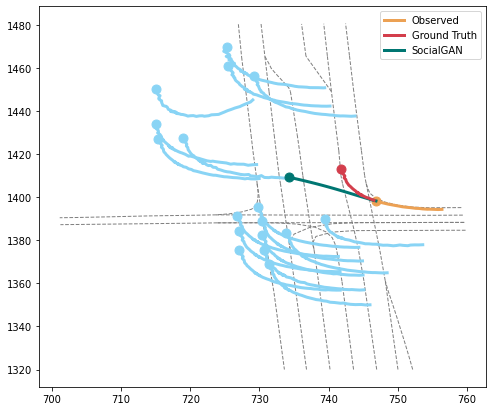

[35208, 30881, 2828, 19851, 27669, 14988, 3847, 5513, 38119, 11992, 9212, 25982, 15694, 29323, 6440, 22160, 10259, 6879, 13158, 22440, 34816, 16547, 21460, 5369, 7131, 11222, 21464, 18710, 23640, 5719, 19347, 32321]
[array([[ 1.45356596e-01,  2.63067544e-01],
       [ 1.38999745e-01,  4.00482148e-01],
       [ 1.31425574e-01,  6.09177470e-01],
       [ 1.24970995e-01,  7.16327310e-01],
       [ 1.23822086e-01,  7.44687438e-01],
       [ 1.27035439e-01,  6.98856294e-01],
       [ 1.30553961e-01,  6.14823997e-01],
       [ 1.31951481e-01,  5.37299156e-01],
       [ 1.27759695e-01,  4.78009343e-01],
       [ 1.16571307e-01,  4.29501832e-01],
       [ 1.00778185e-01,  3.84171903e-01],
       [ 8.36385339e-02,  3.38935971e-01],
       [ 6.73955157e-02,  2.94046104e-01],
       [ 5.31269610e-02,  2.51294971e-01],
       [ 4.11120057e-02,  2.12850243e-01],
       [ 3.12055349e-02,  1.80668354e-01],
       [ 2.34176219e-02,  1.52901173e-01],
       [ 1.72682628e-02,  1.31394088e-01],
       [ 

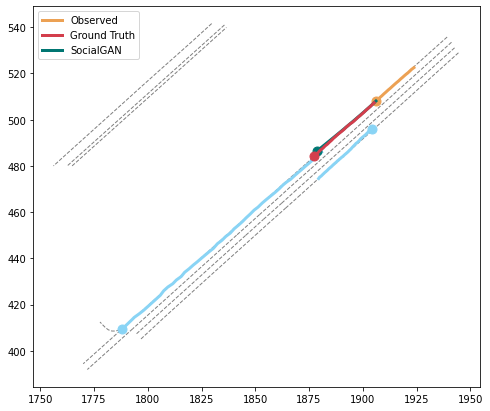

[35208, 30881, 2828, 19851, 27669, 14988, 3847, 5513, 38119, 11992, 9212, 25982, 15694, 29323, 6440, 22160, 10259, 6879, 13158, 22440, 34816, 16547, 21460, 5369, 7131, 11222, 21464, 18710, 23640, 5719, 19347, 32321]


KeyError: 2828

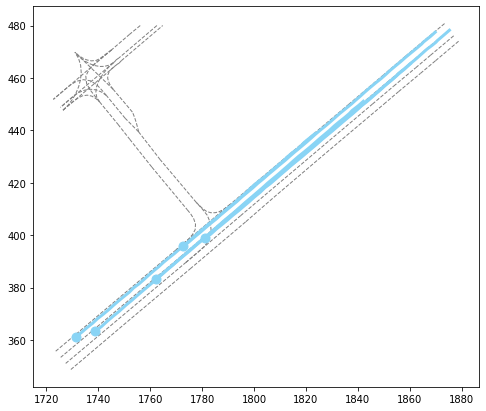

In [29]:
# print(seq_id)
# print(keys)
for i in range(32):
    plot_seq(i)

In [308]:
print("Network \t ADE \t FDE \t MR")
# mean_min_ade = sum(min_ade_LSTM) / len(min_ade_Social)
# mean_min_fde = sum(min_fde_LSTM) / len(min_fde_Social)
# miss_rate = sum(n_misses_LSTM) / len(n_misses_Social)

# print("LSTM: \t", end="")
print(mean_min_ade, mean_min_fde, miss_rate)

mean_min_ade = sum(min_ade_Social) / len(min_ade_Social)
mean_min_fde = sum(min_fde_Social) / len(min_fde_Social)
miss_rate = sum(n_misses_Social) / len(n_misses_Social)

print("Social GAN: \t", end="")
print(mean_min_ade, mean_min_fde, miss_rate)


Network 	 ADE 	 FDE 	 MR
21.55425499495679 11.780265279015197 1.0
Social GAN: 	21.954185639362713 9.99326419144468 1.0


In [254]:
print(np.array(pred[3861][0]).shape)
a = np.array([])
b = np.zeros((11, 11, 1))
print(np.append(a, b).shape)

(30, 2)
(121,)


In [141]:
print(b.shape)
barr = [[i] for i in b]
print(np.array(barr).shape)

(11, 11, 1)
(11, 1, 11, 1)


In [222]:
print(np.array(barr).shape)
carr = [np.array(i)[0,:,:] for i in barr]
print(np.array(carr).shape)

(11, 1, 11, 1)
(11, 11, 1)
